Monthly car sales in Quebec 1960-1968

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [84]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [85]:
cars_df = pd.read_csv("data/car_sales/monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


Remove last row

In [86]:
cars_df = cars_df.iloc[:-1]

Let's change it into datetime format for nicer plots.

In [87]:
cars_df["dt"] = pd.to_datetime(cars_df["Month"])

Rename the long name in column `Monthly car sales in Quebec 1960-1968` for just `sales`.

In [88]:
cars_df = cars_df.rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)
cars_df.tail()

,Month,sales,dt
103,1968-08,16722.0,1968-08-01
104,1968-09,14385.0,1968-09-01
105,1968-10,21342.0,1968-10-01
106,1968-11,17180.0,1968-11-01
107,1968-12,14577.0,1968-12-01


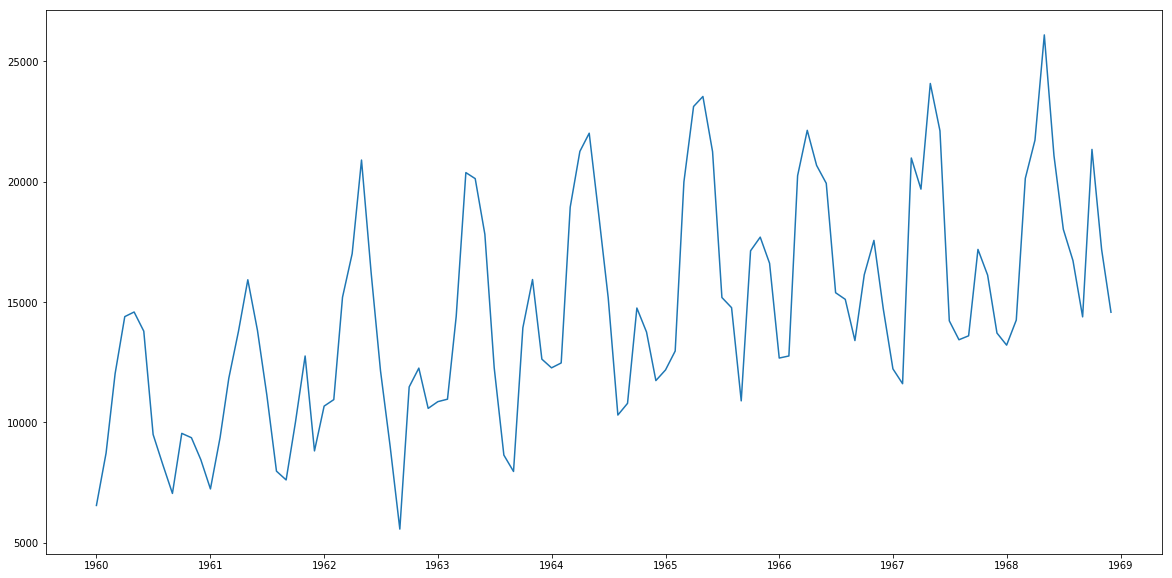

In [89]:
plt.plot(cars_df["dt"], cars_df["sales"])
plt.show()

Let's check if there is no missing data. For example, let's check if each year has 12 months.

In [90]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Train - dev - test split

Here we cannont do random spliting later we will explain why. Our split should be based on time.

In [91]:
Xy = cars_df[['dt', 'sales']]

def create_X_and_y(Xy, target_column='sales'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1967'"))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1967' and dt < '1968'"))
    X_test, y_test = create_X_and_y(Xy.query("dt >= '1968'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Simplest prediction: average of previous sales

In [92]:
y_dev_hat = np.ones(len(y_dev)) * y_train.mean()

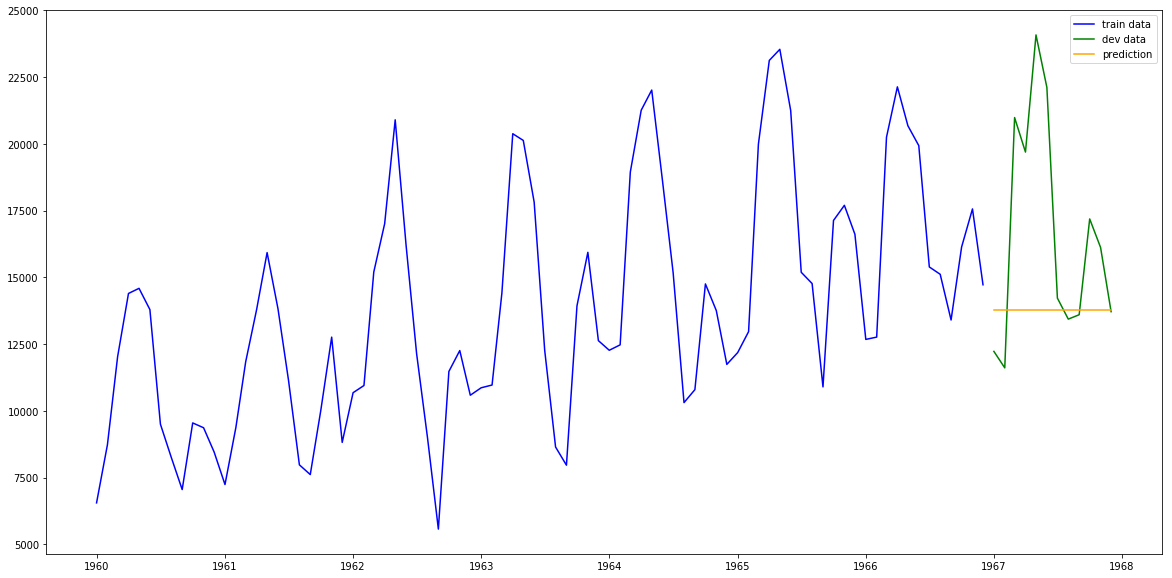

In [93]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We see that this is not very good prediction. However, we will use it as our __baseline__, that is a starting point for further improvments. For that let's calculate mean square error (MSE) and root of mean square error (RMSE) which will serve us for comparation with better predictions.

In [94]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_dev, y_dev_hat), np.sqrt(mean_squared_error(y_dev, y_dev_hat))

(23847172.57993197, 4883.356691859808)

## Average of the previous year

So let's take the last 12 values and calculate mean.

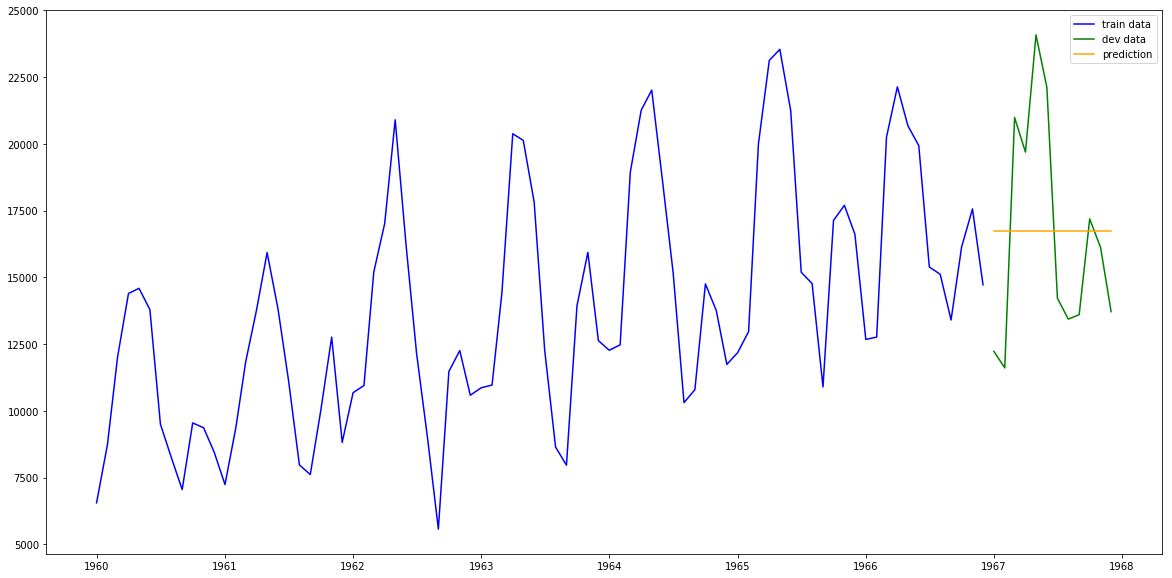

In [95]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

This time it looks better.

In [96]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

So we have also improved RMSE.

## Taking advantage of knowing previous month

Often, we know the value for the previous month and we want to predict just the next month. For this we add to our feature set $X$ the value of the previous month. For that we have python method `shift`. Any previous value is called __lag__.

In [97]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head()

,dt,sales,sales-1
0,1960-01-01,6550.0,NaN
1,1960-02-01,8728.0,6550.0
2,1960-03-01,12026.0,8728.0
3,1960-04-01,14395.0,12026.0
4,1960-05-01,14587.0,14395.0


In [98]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

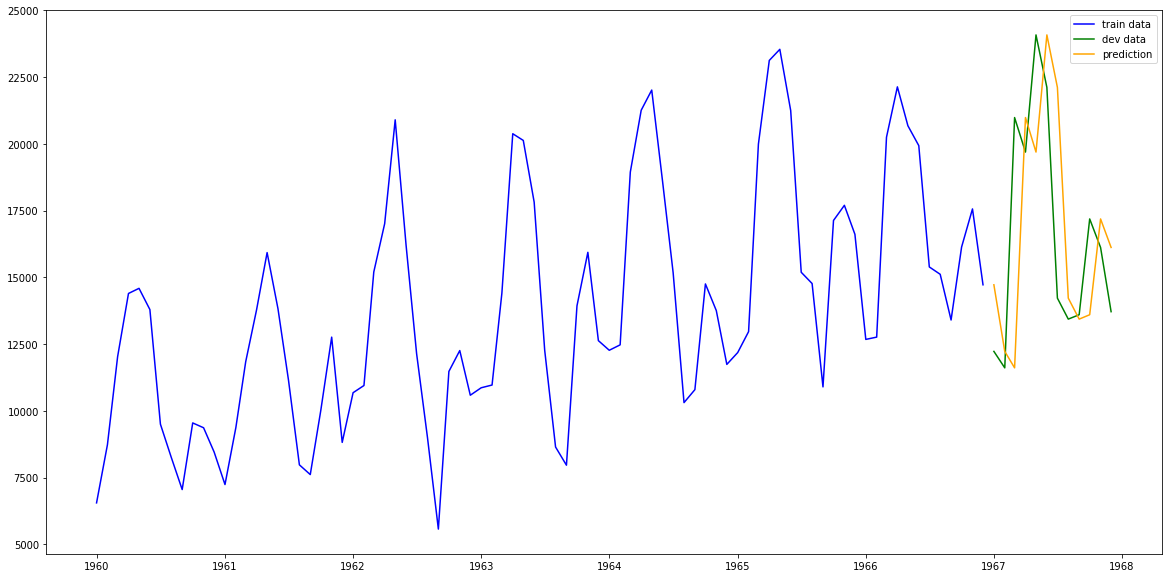

In [99]:
y_dev_hat = X_dev['sales-1']
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [100]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

## Autocorrelation and Autoregression (AR)

It is clear that data there is some relation between values for December 1966 and December 1965. In order to detect them we can calculate correlation with __lags__ of the sales. Let's see how we can do this. 

In [101]:
N_lags = 12

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(Xy, N_lags)
autocorrelations = Xy_with_lags.iloc[N_lags:].drop("dt", axis=1).corr()['sales']

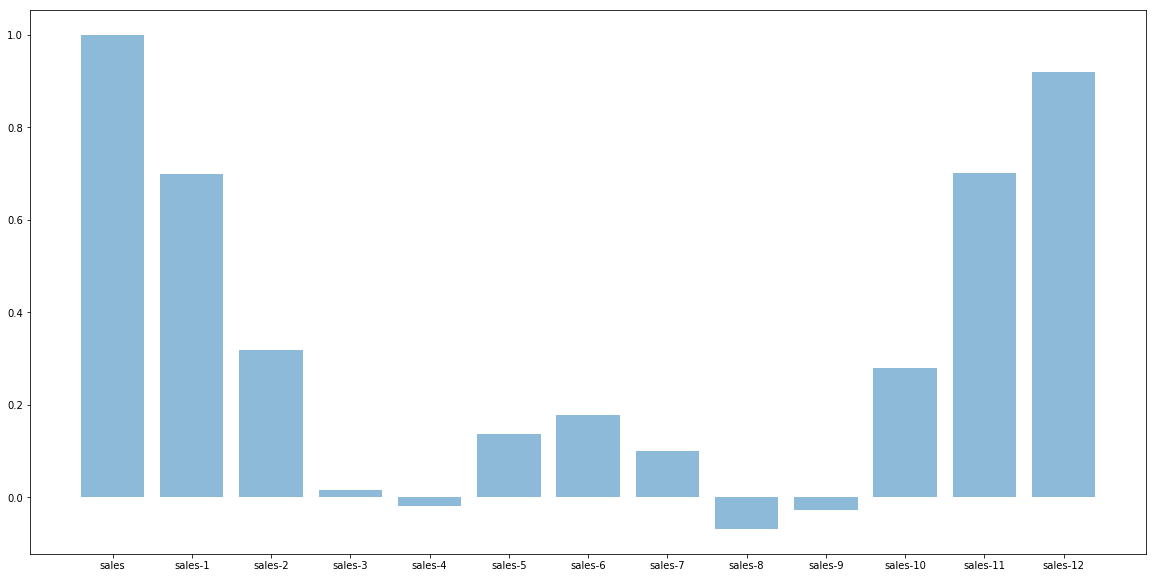

In [102]:
plt.bar(autocorrelations.index, autocorrelations, align='center', alpha=0.5)
plt.show()

Now we will choose columns that are highly correlated with `sales`.

In [103]:
columns_for_ar = autocorrelations[np.abs(autocorrelations) > 0.15].index[1:]
columns_for_ar

Index(['sales-1', 'sales-2', 'sales-6', 'sales-10', 'sales-11', 'sales-12'], dtype='object')

At the begning of our dataser we have lots of `NaN`s. Let's remove them.

In [104]:
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1960-01-01,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-04-01,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-05-01,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
Xy_with_lags = Xy_with_lags.iloc[N_lags:].reset_index(drop=True)
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1961-01-01,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
1,1961-02-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
2,1961-03-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
3,1961-04-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
4,1961-05-01,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0


In [109]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

from sklearn.linear_model import LinearRegression

def train_and_test_linear_model(X_train, y_train, X_dev, y_dev):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_dev_hat = reg.predict(X_dev)
    return reg, np.sqrt(mean_squared_error(y_dev, y_dev_hat))


reg, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

rmse

2014.6596936086883

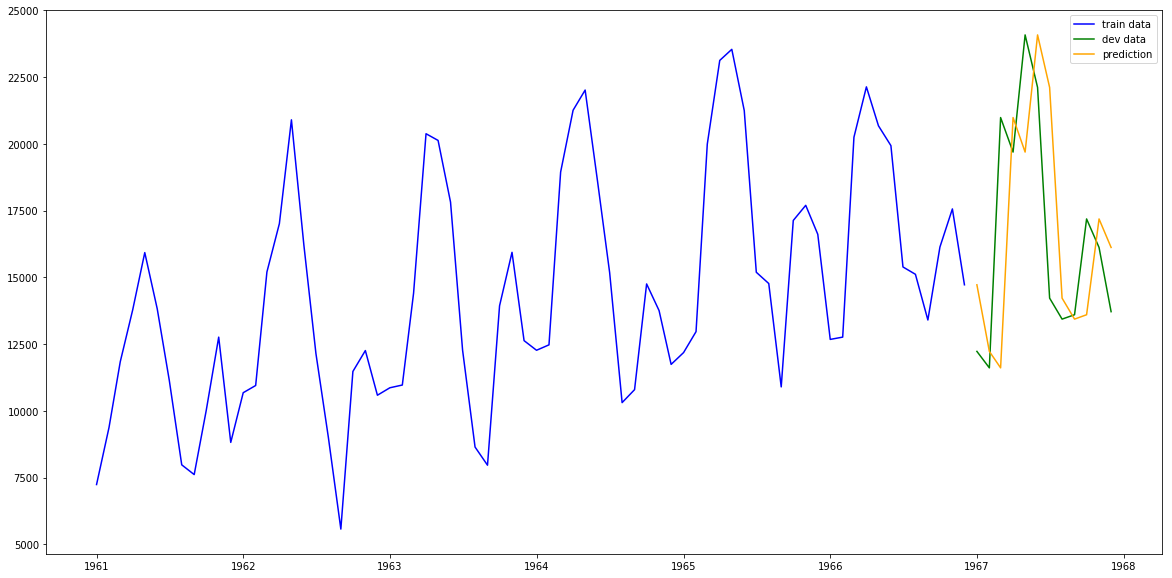

In [82]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We have improved the performance twice!

We can also use all 12 columns. Sometimes it works well, sometimes not.

In [111]:
columns_for_ar = ["sales-" + str(i) for i in range(1, 13)]

reg_all_columns, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

rmse

2009.4533750232415

So this time better, Nice.

However very often in practice we would like to predict the sales for entire year. So let's assume that we are in January 1967 and what to forecast our sales for 1967 monthly. This way the company would know how to optimize stocks for each month. However, this means that when we predict the value for April we do not know what is real value for January, February and March. So what we will predict the sales for January and than use this as a feature for predicting February. And so on. Let's see how we are going to program that.

In [114]:
x_dev = list(y_train[-1:-13:-1])
y_dev_hat = []
for i in range(12):
    y_hat = reg_all_columns.predict([x_dev])[0]
    y_dev_hat.append(y_hat)
    x_dev.pop(-1)
    x_dev = [y_hat] + x_dev
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1894.0145703758449

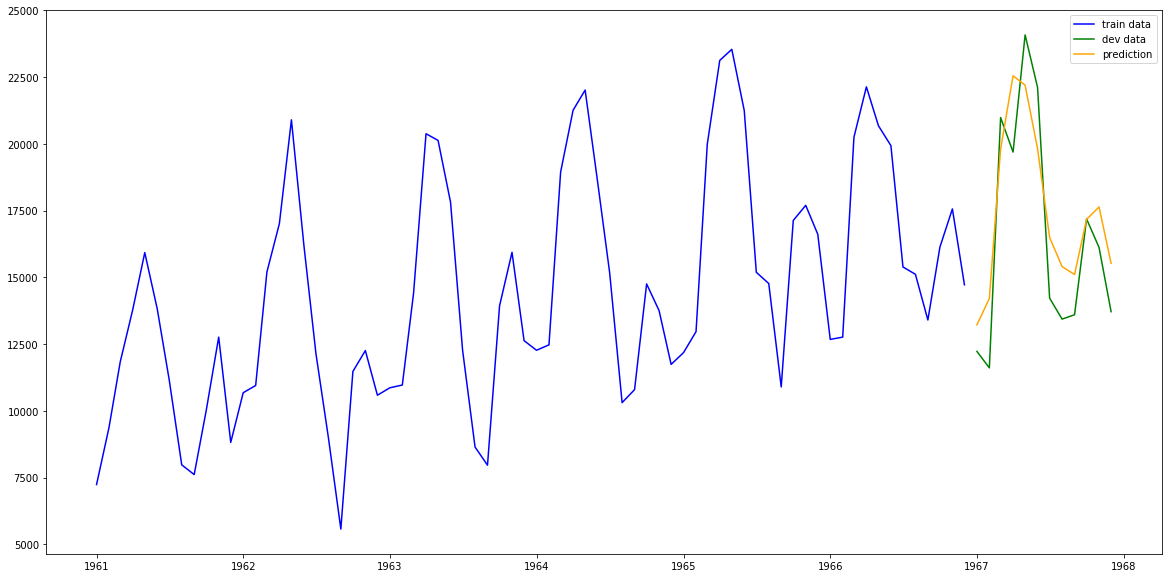

In [115]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We can even go further and train 12 models, that predict future data.

In [131]:
N_models = 1
N_lags = 12

Xy_with_lags = create_lags(Xy, N_lags + N_models - 1).iloc[N_lags + N_models - 1:]

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

for i in range(1, N_models + 1):
    reg = LinearRegression()
    X_train.iloc[:, range(i, i+N_lags)]

In [121]:
def train_and_test_linear_model(X_train, y_train, X_test, y_test):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_test_hat = reg.fit(X_test)
    return reg, np.sqrt(mean_squared_error(y_dev, y_dev_hat))

## K-nearest neighborhood 

In [29]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors=4)

reg.fit(X_train.drop("dt", axis=1), y_train)

x_dev = list(y_train[-1:-13:-1])
y_dev_hat = []
for i in range(12):
    y_hat = reg.predict([x_dev])[0]
    y_dev_hat.append(y_hat)
    x_dev.pop()
    x_dev = [y_hat] + x_dev
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1659.9309144133078

## Sesonality adjustment

In [30]:
Xy_with_lags["year_diff"] = Xy_with_lags["sales"] - Xy_with_lags["sales-12"] 

In [31]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1773.1012131860862


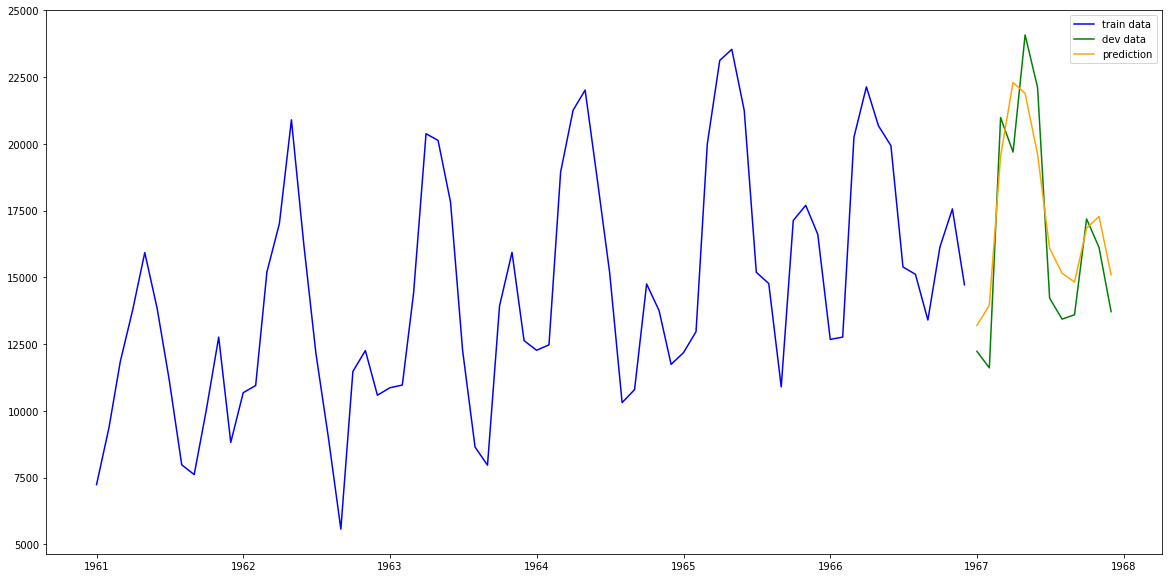

In [32]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [33]:
model_fit = model.fit(maxlag=13)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1717.996621764539


## Moving Agerage (MA)

In [34]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [35]:
for p in range(12):
    for d in range(12):

        try:
            arima_mod=ARMA(y_train,(p,d)).fit(transparams=True)

            x=arima_mod.aic

            x1= p,d
            print (x1,x)

            aic.append(x)
            pdq.append(x1)
        except:
            pass
            # ignore the error and go on


(0, 0) 1411.4421958519445
(0, 1) 1369.6560057942504
(0, 4) 1346.2455825874106
(0, 5) 1348.1385285047875
(1, 0) 1364.3334223861737
(1, 1) 1356.8392228172083
(1, 2) 1350.4104636742964
(1, 3) 1356.278373262507


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-pack

(1, 4) 1350.8285550404032
(1, 5) 1349.5843296622609


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 6) 1357.4466117080801
(1, 7) 1344.5846439425623


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 8) 1337.6453647504072
(2, 0) 1350.646465744407
(2, 1) 1352.3940974414606
(2, 2) 1346.7770721087593
(2, 3) 1362.1589331659327
(3, 0) 1352.095615131118


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1) 1378.0724433630744
(3, 2) 1336.264814660366
(3, 3) 1338.101717343617
(4, 0) 1349.3032415245332


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/

(4, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/E

(4, 3) nan
(5, 0) 1350.6319535409466
(6, 0) 1347.3408451033417
(6, 2) 1328.5431153784991
(7, 0) 1348.9532170216924
(7, 2) 1320.209991877727


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: divide by zero encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(7, 7) nan
(8, 0) 1350.711960703919


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(8, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(8, 11) 1346.1730573010811
(9, 0) 1347.1925043505396


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(9, 2) 1316.1418710347168
(10, 0) 1334.7536020305633
(10, 1) 1324.2244265706738


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(10, 2) nan
(11, 0) 1318.3548177670439
(11, 1) 1317.3906578467675


In [36]:
for p in range(12):
    for d in range(6):
        for q in range(6):
            try:
                arima_mod=ARIMA(y_train,(p,d,q)).fit(transparams=True)

                x=arima_mod.aic

                x1= p,d,q
                print (x1,x)

                aic.append(x)
                pdq.append(x1)
            except:
                pass
                # ignore the error and go on


(0, 0, 0) 1411.4421958519445
(0, 0, 1) 1369.6560057942504
(0, 0, 4) 1346.2455825874106
(0, 0, 5) 1348.1385285047875
(0, 1, 0) 1353.5979533883183
(0, 1, 1) 1350.879005838027
(0, 1, 2) 1351.5839639535807
(0, 1, 3) 1332.7556072569503


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 1, 4) 1327.6296793145307
(0, 1, 5) 1320.230571386666
(0, 2, 0) 1364.5548817165895
(0, 2, 1) 1341.655233005235
(0, 2, 2) 1338.5679612713673
(0, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 0, 0) 1364.3334223861737
(1, 0, 1) 1356.8392228172083
(1, 0, 2) 1350.4104636742964
(1, 0, 3) 1356.278373262507


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-pack

(1, 0, 4) 1350.8285550404032
(1, 0, 5) 1349.5843296622609
(1, 1, 0) 1351.555348293905


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/

(1, 1, 2) 1338.327430565182
(1, 1, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 4) nan
(1, 2, 0) 1362.0830078339213
(1, 2, 2) 1340.47638116353


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 4) 1323.159651800497
(2, 0, 0) 1350.646465744407
(2, 0, 1) 1352.3940974414606
(2, 0, 2) 1346.7770721087593
(2, 0, 3) 1362.1589331659327
(2, 1, 0) 1350.476832456297
(2, 1, 3) 1325.2087301022868
(2, 1, 4) 1324.057696991597


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 5) 1317.9339066508912
(2, 2, 0) 1363.54366586171
(2, 2, 2) 1320.1458602096113


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 2, 4) 1316.6170274392573
(3, 0, 0) 1352.095615131118


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 1) 1378.0724433630744
(3, 0, 2) 1336.264814660366
(3, 0, 3) 1338.101717343617
(3, 1, 0) 1337.6968657454388


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/E

(3, 2, 0) 1354.5934322838796
(3, 2, 2) 1322.9350057953627


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 2, 4) 1315.8863134959483


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 2, 5) 1323.1806992273982
(4, 0, 0) 1349.3032415245332


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 0, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 0, 3) nan
(4, 1, 0) 1336.684466507792


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 4) 1319.0162987044866


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 1, 5) nan
(4, 2, 0) 1336.1832581601966
(4, 2, 1) 1325.8742617847001


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 2, 4) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: divide by zero encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 2, 5) nan
(5, 0, 0) 1350.6319535409466
(5, 1, 0) 1336.995694361749


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(5, 1, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(5, 1, 4) nan
(5, 2, 0) 1336.217822000039


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(5, 2, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(5, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


(6, 0, 0) 1347.3408451033417
(6, 0, 2) 1328.5431153784991
(6, 1, 0) 1338.5368905404825
(6, 2, 0) 1338.047849347718


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(6, 2, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(6, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(6, 2, 4) nan
(7, 0, 0) 1348.9532170216924
(7, 0, 2) 1320.209991877727
(7, 1, 0) 1337.6032152168232
(7, 2, 0) 1339.9842433416943


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(7, 2, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(7, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(7, 2, 4) 1329.3892435810399
(8, 0, 0) 1350.711960703919


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(8, 0, 2) nan
(8, 1, 0) 1329.2024696574686


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(8, 1, 4) 1338.5583490220704
(8, 2, 0) 1341.824423304118


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(8, 2, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(8, 2, 3) nan
(9, 0, 0) 1347.1925043505396


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(9, 0, 2) 1316.1418710347168
(9, 1, 0) 1312.697419209465
(9, 1, 1) 1292.62626021671


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(9, 1, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(9, 1, 4) 1320.3986702631316
(9, 2, 0) 1339.4497304838708
(9, 2, 1) 1303.9536644455548


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(9, 2, 3) nan
(10, 0, 0) 1334.7536020305633
(10, 0, 1) 1324.2244265706738


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(10, 0, 2) nan
(10, 1, 0) 1291.907210825189
(10, 1, 1) 1285.918310810186


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(10, 1, 4) nan
(10, 2, 0) 1326.2657736622875
(10, 2, 1) 1283.754156229744


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(10, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(10, 2, 5) nan
(11, 0, 0) 1318.3548177670439
(11, 0, 1) 1317.3906578467675


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(11, 1, 1) 1278.3399856989831
(11, 2, 4) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [37]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

2501.305981229266


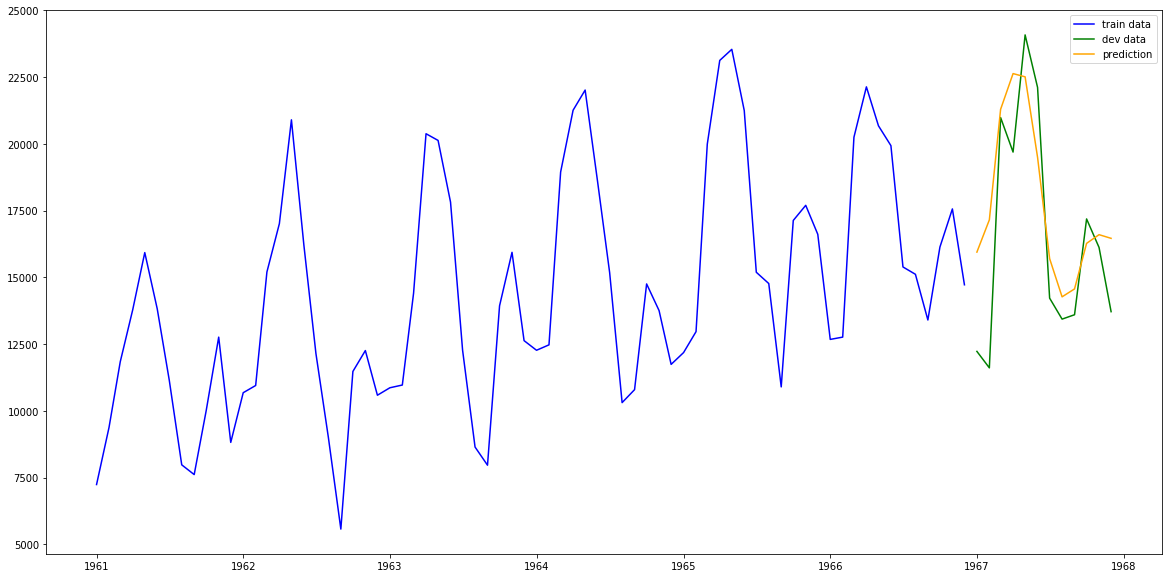

In [38]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [39]:
model = ARIMA(y_train, order=(5,1,0))
model_fit = model.fit(disp=0)

In [40]:
y_dev_hat = model_fit.predict(start=len(y_train)-1, end=len(y_train)+11)    
y_dev_hat

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [ ]:
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

In [ ]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
